# Squared Exponential kernel Gaussian process - PriorCVAE


This is a demo notebook to showcase the usage of PriorCVAE model on a Gaussian process dataset which is generated using a SquaredExponential kernel.

In [1]:
import random as rnd

import numpy as np 
import matplotlib.pyplot as plt
import numpyro
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi
numpyro.set_host_device_count(4)
import jax
import optax
from jax import random
import jax.numpy as jnp

from priorCVAE.models import MLPEncoder, MLPDecoder, VAE
from priorCVAE.priors import GP, SquaredExponential
from priorCVAE.mcmc import run_mcmc_vae, vae_mcmc_inference_model
from priorCVAE.datasets import GPDataset
from priorCVAE.trainer import VAETrainer
from priorCVAE.losses import SquaredSumAndKL

import jax.config as config
config.update("jax_enable_x64", True)

### Configuration

In [2]:
args = {
        "conditional": True,
        
        # architecture
        "input_dim" : 80,
        "hidden_dim": 60,
        "latent_dim": 40,
        
        # VAE training    
        "batch_size": 500,
        "num_iterations": 4000,
        "learning_rate": 1e-3,
        "vae_var": 1.,

        # MCMC inference
        "true_ls": 0.2,
        "num_warmup": 1000,
        "num_mcmc_samples": 4000,
        "num_chains": 4,
        "thinning": 1,
       }

### Generate data

We generate the data using an SquaredExponential kernel with lengthscale that is uniformly sampled. We plot a sample from the GP and plot the trajectories and lengthscales.

In [3]:
kernel = SquaredExponential()

gp_data_generator = GPDataset(n_data=args["input_dim"], kernel=kernel, sample_lengthscale=True)  

In [4]:
sample_x_train, sample_y_train, sample_ls_train = gp_data_generator.simulatedata(n_samples=1000)
x_test, y_test, ls_test = gp_data_generator.simulatedata(n_samples=1000)

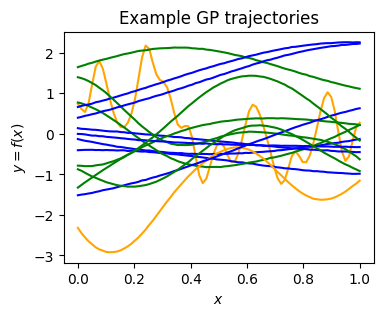

In [5]:
fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    if sample_ls_train[i] <= 0.2:
        col = 'orange'
    elif sample_ls_train[i] <= 0.6:
        col = 'green'
    else:
        col = 'blue'
    ax.plot(sample_x_train[i], sample_y_train[i], color=col)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('Example GP trajectories')

plt.show()

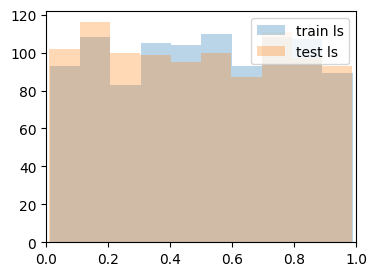

In [6]:
# Plot sample lengthscales
plt.figure(figsize=(4,3))
plt.hist(sample_ls_train[:, 0], alpha = 0.3, label = 'train ls') 
plt.hist(ls_test[:, 0],  alpha = 0.3, label = 'test ls') 
plt.xlim(0,1)
plt.legend()
plt.show()

### PriorCVAE Model

We define the PriorCVAE model, optimizer, and initialize the parameters of the model randomly.

In [7]:
conditional = args["conditional"]
out_dim = args["input_dim"]
hidden_dim = args["hidden_dim"]
latent_dim = args["latent_dim"]
batch_size = args["batch_size"]
num_iterations  = args["num_iterations"]
true_ls = args["true_ls"]
learning_rate = args["learning_rate"]
vae_var = args["vae_var"]

In [8]:
encoder = MLPEncoder(hidden_dim, latent_dim)
decoder = MLPDecoder(hidden_dim, out_dim)
model = VAE(encoder, decoder)

optimizer = optax.adam(learning_rate=learning_rate)
loss = SquaredSumAndKL(conditional=conditional, vae_var=vae_var)

### Train the model

Train the model and plot the train loss and the test loss.

In [9]:
trainer = VAETrainer(model, optimizer, loss=loss)
trainer.init_params(sample_y_train[0], c=sample_ls_train[0])

test_set = (x_test, y_test, ls_test)
loss_vals, test_vals, time_taken = trainer.train(gp_data_generator, test_set, num_iterations)

print(f'Training of {num_iterations} iterations took {round(time_taken)} seconds')

[    1] training loss: 11529.362, test loss: 93141.250
[   11] training loss: 6001.112, test loss: 57725.944
[   21] training loss: 4793.328, test loss: 48190.750
[   31] training loss: 3310.808, test loss: 41640.577
[   41] training loss: 3562.968, test loss: 36134.444
[   51] training loss: 3152.750, test loss: 31000.205
[   61] training loss: 2952.322, test loss: 28374.182
[   71] training loss: 2562.064, test loss: 26774.894
[   81] training loss: 2476.201, test loss: 25298.895
[   91] training loss: 2146.002, test loss: 24195.028
[  101] training loss: 2639.023, test loss: 23376.195
[  111] training loss: 2010.546, test loss: 22358.987
[  121] training loss: 2436.381, test loss: 21773.554
[  131] training loss: 2079.129, test loss: 21169.331
[  141] training loss: 1752.029, test loss: 20328.595
[  151] training loss: 2087.982, test loss: 19659.796
[  161] training loss: 2142.624, test loss: 19818.314
[  171] training loss: 1627.968, test loss: 19447.514
[  181] training loss: 1686

[ 1531] training loss: 1009.361, test loss: 9838.952
[ 1541] training loss: 1009.917, test loss: 9848.963
[ 1551] training loss: 898.045, test loss: 9866.250
[ 1561] training loss: 1050.141, test loss: 9818.941
[ 1571] training loss: 1015.089, test loss: 9737.085
[ 1581] training loss: 1008.481, test loss: 9831.927
[ 1591] training loss: 811.549, test loss: 9686.541
[ 1601] training loss: 995.340, test loss: 9718.363
[ 1611] training loss: 970.200, test loss: 9793.366
[ 1621] training loss: 878.943, test loss: 9783.713
[ 1631] training loss: 980.681, test loss: 9725.359
[ 1641] training loss: 1004.406, test loss: 9718.836
[ 1651] training loss: 975.571, test loss: 9793.226
[ 1661] training loss: 841.816, test loss: 9700.817
[ 1671] training loss: 928.074, test loss: 9734.064
[ 1681] training loss: 991.801, test loss: 9699.384
[ 1691] training loss: 981.352, test loss: 9638.866
[ 1701] training loss: 974.400, test loss: 9843.344
[ 1711] training loss: 946.290, test loss: 9731.045
[ 1721

[ 3101] training loss: 894.014, test loss: 9070.137
[ 3111] training loss: 927.325, test loss: 9137.576
[ 3121] training loss: 979.588, test loss: 9196.568
[ 3131] training loss: 715.940, test loss: 9085.253
[ 3141] training loss: 799.476, test loss: 9165.258
[ 3151] training loss: 942.765, test loss: 9107.737
[ 3161] training loss: 846.994, test loss: 9131.910
[ 3171] training loss: 893.049, test loss: 9205.041
[ 3181] training loss: 856.478, test loss: 9159.241
[ 3191] training loss: 832.475, test loss: 9162.109
[ 3201] training loss: 949.291, test loss: 9183.104
[ 3211] training loss: 939.514, test loss: 9127.054
[ 3221] training loss: 819.794, test loss: 9169.395
[ 3231] training loss: 810.514, test loss: 9046.090
[ 3241] training loss: 819.751, test loss: 9145.924
[ 3251] training loss: 822.730, test loss: 9174.823
[ 3261] training loss: 927.089, test loss: 9126.815
[ 3271] training loss: 1012.065, test loss: 9059.089
[ 3281] training loss: 774.336, test loss: 9098.177
[ 3291] tra

Text(0.5, 1.0, 'Test loss')

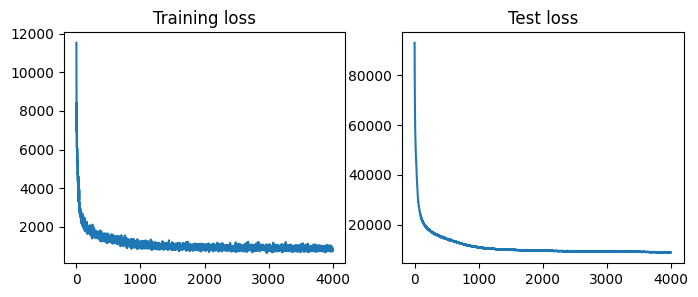

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].plot(range(len(loss_vals)), loss_vals)
axs[0].set_title('Training loss')

axs[1].plot(range(len(test_vals)), test_vals)
axs[1].set_title("Test loss")


### Trained Decoder

We plot a sample of trajectories from the trained decoder model.

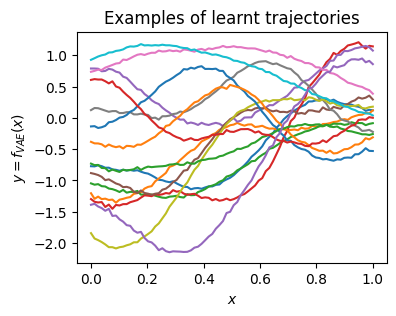

In [11]:
decoder_params = trainer.state.params['decoder']
key = jax.random.PRNGKey(rnd.randint(0, 9999))
rng, z_rng, init_rng = random.split(key, 3)
z = random.normal(z_rng, (batch_size, latent_dim))

decoder = MLPDecoder(hidden_dim, out_dim)

c = true_ls * jnp.ones((z.shape[0], 1))
z_c = jnp.concatenate([z, c], axis=-1)
out = decoder.apply({'params': decoder_params}, z_c)             

fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    ax.plot(sample_x_train[0], out[i,:])
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f_{VAE}(x)$')
ax.set_title('Examples of learnt trajectories')

plt.show()

### Inference with MCMC

We randomly generate observations from the GP.

#### Generate data

Text(0.5, 1.0, 'Ground truth, corresponds to $ls$=0.2')

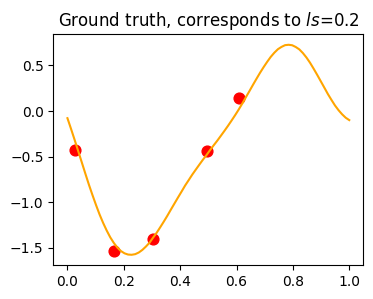

In [12]:
x = sample_x_train[0]

rng_key_draw =  random.PRNGKey(1)
rng_key, rng_key_post, rng_key_preds, rng_key_draw = random.split(rng_key_draw, 4)

kernel = SquaredExponential(lengthscale=true_ls, variance=1.)
gp_predictive = Predictive(GP, num_samples=1)
draws = gp_predictive(rng_key_draw, kernel=kernel, x=x, jitter=1e-6, noise=True)

gp_draw = draws['f'].T
y_draw = draws['y'].T

# indices of data points
obs_idx = jnp.array([2, 13, 24, 39, 48])
y_obs = y_draw[obs_idx,0]
x_obs = x[np.array(obs_idx)]

plt.figure(figsize=(4,3))
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to $ls$=' + str(args["true_ls"]))

### Numpyro model

We define a Nupmyro model to run MCMC.

In [ ]:
# add data to args. This is used by MCMC.
args["y_obs"] = y_obs
args["obs_idx"] = obs_idx

In [13]:
c = true_ls * jnp.ones((1, )) if conditional else None

mcmc_vae, mcmc_vae_samples, t_elapsed = run_mcmc_vae(rng_key_post, vae_mcmc_inference_model, args, decoder, 
                                                     decoder_params, c=c)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]     -0.69      0.18     -0.68     -0.98     -0.39  16636.07      1.00
      f[1]     -0.71      0.18     -0.71     -1.02     -0.42  16856.55      1.00
      f[2]     -0.74      0.18     -0.73     -1.05     -0.46  16740.08      1.00
      f[3]     -0.76      0.19     -0.75     -1.08     -0.47  16664.67      1.00
      f[4]     -0.80      0.18     -0.79     -1.09     -0.50  16826.63      1.00
      f[5]     -0.81      0.19     -0.80     -1.12     -0.51  17040.28      1.00
      f[6]     -0.86      0.18     -0.85     -1.16     -0.58  16922.70      1.00
      f[7]     -0.89      0.17     -0.88     -1.18     -0.61  17037.00      1.00
      f[8]     -0.94      0.16     -0.94     -1.21     -0.68  16845.09      1.00
      f[9]     -0.98      0.16     -0.97     -1.22     -0.72  16773.75      1.00
     f[10]     -1.03      0.15     -1.03     -1.27     -0.78  16732.52      1.00
     f[11]     -1.07      0

Average ESS for all VAE-GP effects : 12831


## Plotting

We plot the trajectory after MCMC.

Text(0.5, 1.0, 'PriorCVAE inference')

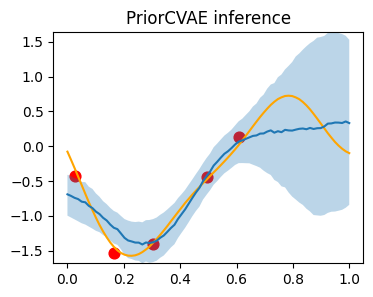

In [14]:
predictive = Predictive(vae_mcmc_inference_model, mcmc_vae_samples)

c = true_ls * jnp.ones((1, )) if conditional else None
predictions_vae = predictive(rng_key_preds, args, decoder, decoder_params, c)["f"]

mean_post_pred_vae = jnp.mean(predictions_vae, axis=0)
hpdi_post_pred_vae = hpdi(predictions_vae, 0.9)
percentiles_vae = np.percentile(predictions_vae, [5.0, 95.0], axis=0)

N_lines = 10

plt.figure(figsize=(4,3))
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to $ls$=' + str(args["true_ls"]))

plt.plot(x, mean_post_pred_vae, label="predicted mean VAE")
plt.fill_between(x, percentiles_vae[0, :], percentiles_vae[1, :], alpha=0.3, interpolate=True, 
                 label="VAE posterior: 90% BCI")

y_min = min(np.concatenate([y_obs, mean_post_pred_vae, percentiles_vae[0, :]]))
y_max = max(np.concatenate([y_obs, mean_post_pred_vae, percentiles_vae[1, :]]))

plt.ylim([y_min, y_max])

plt.title('PriorCVAE inference')